# Wyłudzenia transakcji kartowych

Na podstawie danych zawartych w zbiorze https://www.kaggle.com/mlg-ulb/creditcardfraud dotyczącym wyłudzeń transakcji kartowych, stwórz model SVM, który szacować będzie wystąpienie wyłudzenia.

##### Uwaga:
Zbiór cech jest wynikiem analizy głównych składowych (PCA). Na potrzeby zadania nie jest ważne z jakich danych powstały te cechy, uznajemy że podmiot dla kórego tworzymy model dostarcza nam dane w takie formie.

##### W zadaniu muszą pojawić się co najmniej takie punkty jak:
- Eksploracyjna analiza danych
- Feature Engineering i przygotowanie zbiorów (warto wykorzystać undersampling lub oversamplig)
- Trening modelu i ocena jego jakości
- Komentarze/wnioski na poszczególnych etapach (przy obserwacjach i podejmowaniu decyzji)

### Termin oddania: 26.05.2023 23:59

Data Exploration

Importing libraries and data files 

In [17]:
import os 
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

In [4]:
# Getting data from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

api = KaggleApi()
api.authenticate()

api.dataset_download_files('mlg-ulb/creditcardfraud', unzip=True)



Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [4]:
# Opening data file 

data = pd.read_csv('creditcard.csv')
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Data explorations and initial analysis 

In [7]:
# checking the data shape

data.shape

(284807, 31)

In [5]:
# checking null values 
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


There are no null values in the data. 

In [6]:
# checking class distribution

print(data['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

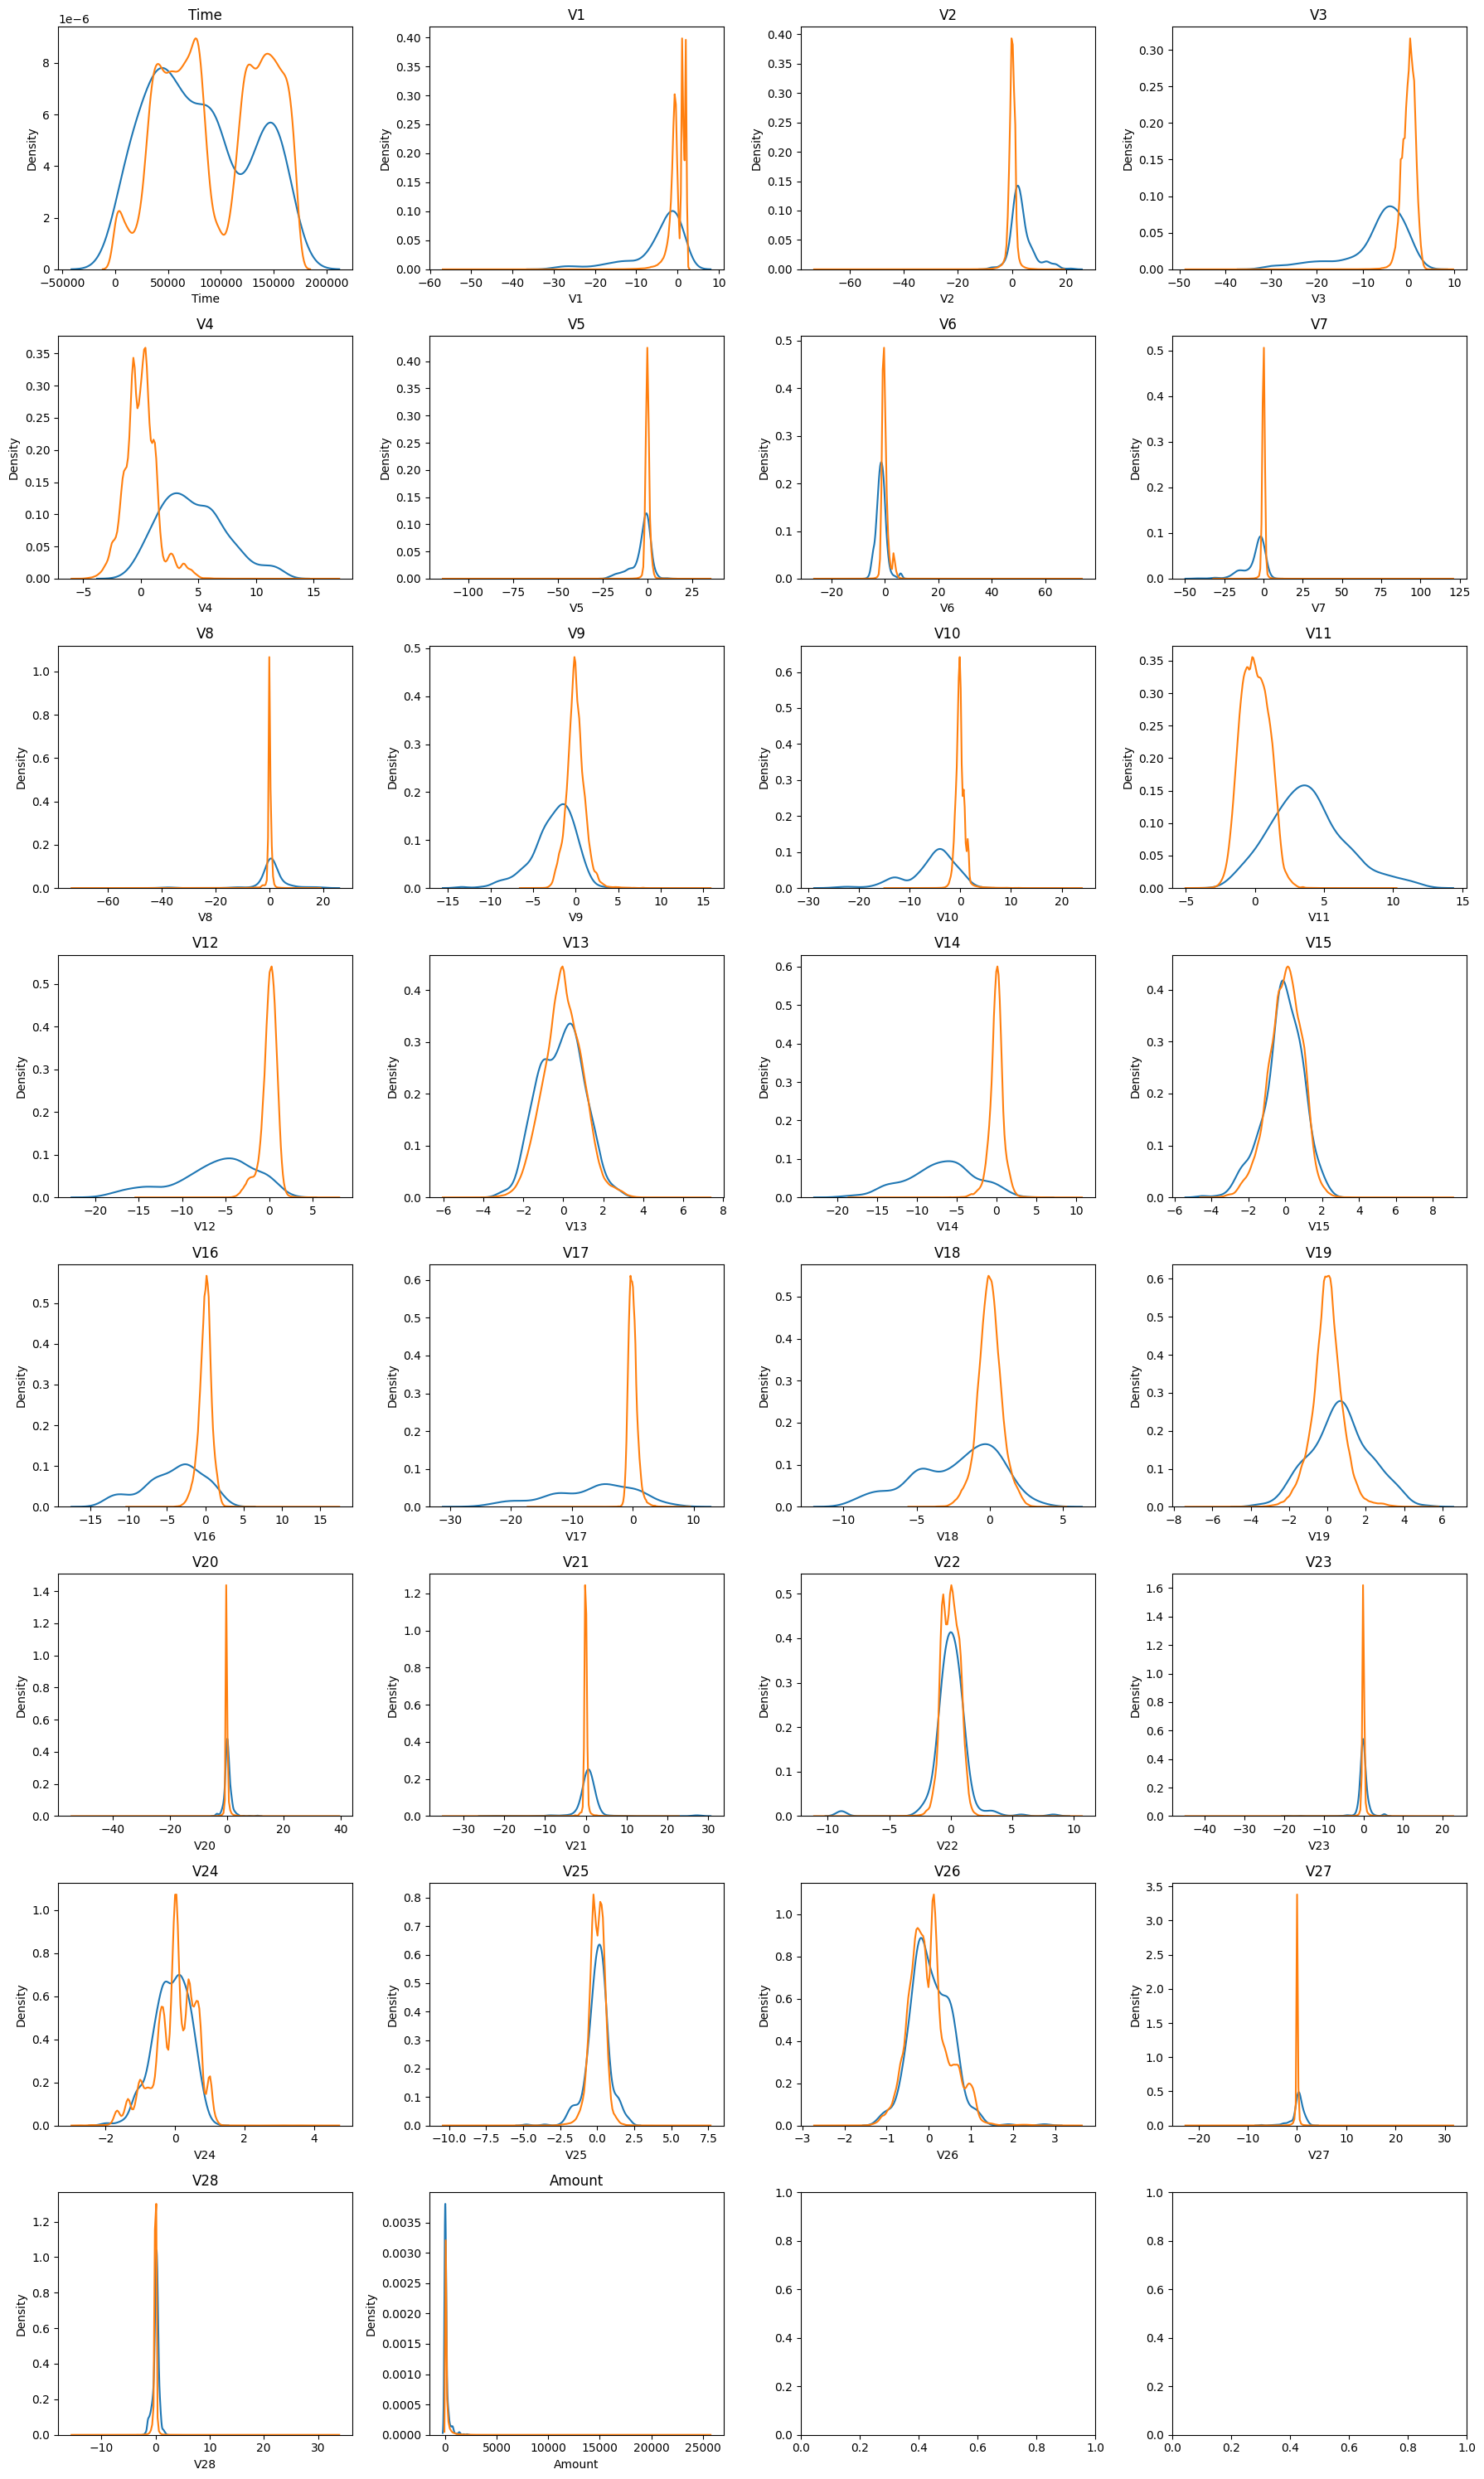

In [9]:
# checking distribution of variables for each class

fraud = data[data['Class'] == 1]
normal = data[data['Class'] == 0]

fig, ax = plt.subplots(8, 4, figsize = (18,30))
ax = ax.flatten()

for i in range(len(data.columns)-1):
    sns.kdeplot(fraud.iloc[:,i], ax=ax[i], label="Fraud")
    sns.kdeplot(normal.iloc[:,i], ax=ax[i], label="Normal")
    ax[i].set_title(data.columns[i])
    
plt.tight_layout()
plt.show()

Analyzing the charts, we notice that variables "V1" to "V28" appear to be already processed. We cannot infer from them whether a given transaction is fraudulent or not. The values of "Time" and "Amount" seem to be more useful as they exhibit some differences between legitimate and illegitimate transactions.

Summary of exploratory data analysis:
 - There are no missing data.
 - We have an issue with imbalanced classes.
 - Variables "V1" to "V28" seem to be already processed, while variables "Time" and "Amount" appear to be more useful.

Feature engineering / data preparation 

Due to the issue of imbalanced classes, we will apply undersampling. We will use RandomUnderSampler from the imblearn library.

In [13]:
# preparing data for model training 

X = data.drop('Class', axis=1)
y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [15]:
# training - SVM model 

svm = SVC()

parameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

svm_grid = GridSearchCV(svm, parameters, n_jobs=-1, cv=5)
svm_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})

Model assessment

In [18]:
y_pred = svm_grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85307
           1       0.04      0.93      0.08       136

    accuracy                           0.96     85443
   macro avg       0.52      0.95      0.53     85443
weighted avg       1.00      0.96      0.98     85443



We can see that our model performs well in detecting fraud (recall is 0.91). However, the precision is low, which means it may generate many false alarms.